### Loading the approximate energy function

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import tqdm
from mol_utils import PotentialModel, mod_pi, extended_mod
from mol_utils import MLP, alpha_sigma

# Model approximating the energy function
state_dict = torch.load('potential_model.pt')
pot_model = PotentialModel([64, 64])
pot_model.load_state_dict(state_dict)

<All keys matched successfully>

### Generating training data

In [2]:
def langevin_dynamics(inp, dt, n_steps):
    """
    Since the energy function is defined on a torus, we `extend` the domain outside (-pi, pi) to 
    make the training of diffusion model easier. 
    """
    x = inp.float()
    for i in tqdm.tqdm(range(n_steps)):
        in_bounds_x = mod_pi(x)
        in_bounds_x = in_bounds_x.detach().clone().requires_grad_(True)
        pot_pred = pot_model(in_bounds_x)
        drift = -torch.autograd.grad(pot_pred.sum(), in_bounds_x)[0]
        x = x + 0.5 * dt * drift + torch.sqrt(dt) * torch.randn_like(x)
        x = extended_mod(x).detach()
    return x

_delta = 0.05
xs = np.arange(-np.pi, np.pi + _delta, _delta)
ys = np.arange(-np.pi, np.pi + _delta, _delta)
x, y = np.meshgrid(xs, ys)
inp = torch.tensor([x, y]).view(2, -1).T

traj = langevin_dynamics(inp, torch.tensor(0.001), 1000)

/var/folders/zv/qtb0nk453wd95ll0x83096j40000gp/T/ipykernel_34400/864036279.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  inp = torch.tensor([x, y]).view(2, -1).T
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.99it/s]


In [3]:
from mol_utils import visualize_energy

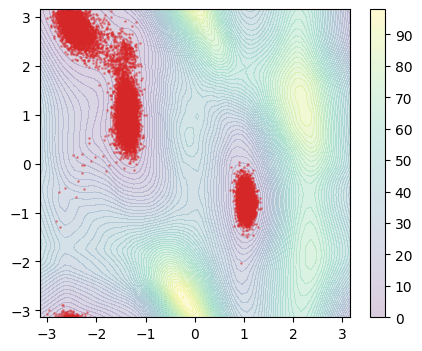

In [4]:
traj_numpy = mod_pi(traj).numpy()
fig, ax = plt.subplots(figsize=(5, 4))
visualize_energy(fig, ax, pot_model, alpha=0.2)
ax.scatter(traj_numpy[:, 0], traj_numpy[:, 1], color='C3', s=1, alpha=0.4)

In [5]:
full_dataset = traj.detach()
for i in range(4):
    traj = langevin_dynamics(traj, torch.tensor(0.001), 1000)
    full_dataset = torch.cat([full_dataset, traj.detach()])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.05it/s]


### Training diffusion model

In [6]:
# Implementation of adaptive noise schedule as introduced in Kingma and Gao
# "Understanding Diffusion Objectives as the ELBO with Simple Data Augmentation" (NeurIPS 2023)
class ImportanceSampler(nn.Module):
    def __init__(self, l_min, l_max, n_bins, p=None, eta=0.999):
        super().__init__()
        self.n_bins = n_bins
        self.l_min = l_min
        self.l_max = l_max
        self.bin_width = (l_max - l_min) / n_bins
        self.eta = eta
        
        # p: shape [n_bins]
        if p is None:
            p = torch.ones(n_bins, dtype=torch.float32)
        else:
            p = p.clone().detach().float()
        
        # Register p and bin_edges as buffers so they’re moved automatically 
        # to the correct device (CPU/GPU) and saved with state dict,
        # but are not considered trainable parameters.
        self.register_buffer("p", p)
        bin_edges = torch.linspace(l_min, l_max, n_bins + 1, dtype=torch.float32)
        self.register_buffer("bin_edges", bin_edges)

    def update(self, l, v):
        """
        Updates self.p at the bin index corresponding to `l`.
        
        l: scalar or 1D tensor
        v: scalar or 1D tensor (same shape as l)
        """
        # Convert to float (avoid potential double -> long issues).
        l = l.float()
        v = v.float()

        # Compute bin indices
        bin_indices = torch.floor((l - self.l_min) / self.bin_width).long()

        # Make sure indices are in range [0, n_bins - 1]
        bin_indices = torch.clamp(bin_indices, 0, self.n_bins - 1)

        # In-place update
        with torch.no_grad():
            self.p[bin_indices] = self.p[bin_indices] * self.eta + (1 - self.eta) * v

    def prob(self, l):
        """
        Returns the probability density at l according to the current p distribution.
        
        l: scalar or 1D tensor
        """
        l = l.float()
        bin_indices = torch.floor((l - self.l_min) / self.bin_width).long()
        bin_indices = torch.clamp(bin_indices, 0, self.n_bins - 1)
        return self.p[bin_indices] / self.p.sum() / self.bin_width

    def transform(self, l):
        """
        Applies the "cumulative" transform to map l in [l_min, l_max] to new values
        according to the histogram distribution in p.
        
        l: scalar or 1D tensor
        """
        l = l.float()
        cumsums = self._compute_sums()  # shape [n_bins+1]
        normalized_l = (l - self.l_min) / (self.l_max - self.l_min)
        return self._interp(normalized_l, cumsums, self.bin_edges)

    def prob_and_transform(self, l):
        """
        Returns (prob, transformed_value) for input l.
        """
        l = l.float()
        cumsums = self._compute_sums()
        normalized_l = (l - self.l_min) / (self.l_max - self.l_min)
        transformed = self._interp(normalized_l, cumsums, self.bin_edges)
        
        # Determine bin indices of the transformed value
        bin_indices = torch.floor((transformed - self.l_min) / self.bin_width).long()
        bin_indices = torch.clamp(bin_indices, 0, self.n_bins - 1)

        probs = self.p[bin_indices] / self.p.sum() / self.bin_width
        return probs, transformed

    def _compute_sums(self):
        """
        Computes normalized cumulative sum of p, with a leading 0.0.
        Result shape is [n_bins+1].
        """
        total_mass = self.p.sum()
        cumsums = torch.cumsum(self.p, dim=0) / total_mass
        cumsums = torch.cat([torch.tensor([0.0], device=cumsums.device, dtype=cumsums.dtype), cumsums], dim=0)
        return cumsums

    def _interp(self, x, xp, fp):
        """
        PyTorch equivalent of numpy/jax `interp(x, xp, fp)`.
        * x can be scalar or 1D
        * xp and fp must be 1D and sorted, with same length
        """
        # x < xp[0] => clamp to xp[0], x > xp[-1] => clamp to xp[-1]
        # We'll do a piecewise-linear interpolation using searchsorted.
        # 'right=True' to match numpy.interp’s default behavior.
        indices = torch.searchsorted(xp, x, right=True)
        
        # For any x < xp[0], indices=0 => clamp to 1
        # For any x > xp[-1], indices=len(xp) => clamp to len(xp)-1
        indices = torch.clamp(indices, 1, xp.shape[0] - 1)

        x0 = xp[indices - 1]
        x1 = xp[indices]
        y0 = fp[indices - 1]
        y1 = fp[indices]

        slope = (y1 - y0) / (x1 - x0)
        return y0 + slope * (x - x0)

In [7]:
LAMBDA_MIN, LAMBDA_MAX = -12, 12
def sample_l(batch_size, sampler):
    l = LAMBDA_MIN + (LAMBDA_MAX - LAMBDA_MIN) / batch_size * torch.rand(size=(batch_size,))
    l = l + ((LAMBDA_MAX - LAMBDA_MIN) / batch_size) * torch.arange(batch_size)
    prob_l, reweighted_l = sampler.prob_and_transform(l)
    return prob_l, reweighted_l

In [8]:
def update_importance_sampler(model, sampler, batch_size):
    with torch.no_grad():
        ex_indices = torch.randint(low=0, high=full_dataset.shape[0], size=(batch_size,))
        batch = mod_pi(full_dataset[ex_indices].detach())
        l = LAMBDA_MIN + (LAMBDA_MAX - LAMBDA_MIN) / batch_size * torch.rand(size=(batch_size,))
        l = l + ((LAMBDA_MAX - LAMBDA_MIN) / batch_size) * torch.arange(batch_size)
        alpha, sigma = alpha_sigma(l)
        noisy_batch = alpha.unsqueeze(1) * batch + sigma.unsqueeze(1) * torch.randn_like(batch)    
        preds = model(noisy_batch, l)
        weight = torch.sigmoid(l + 2) ** 0.5
        all_losses = ((preds - batch) ** 2).sum(dim=1) * weight
        sampler.update(l, all_losses)

In [9]:
sampler = ImportanceSampler(LAMBDA_MIN, LAMBDA_MAX, 100, p=None, eta=0.99)

model = MLP(
    hidden_size=128,
    hidden_layers=3,
    emb_size=128,
    time_emb="sinusoidal",
    input_emb="sinusoidal"
)
losses = []
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [10]:
import tqdm
n_steps = 4000
batch_size = 1024
import time
pbar = tqdm.tqdm(range(n_steps)) 
for step in pbar:
    # sample training example
    ex_indices = torch.randint(low=0, high=full_dataset.shape[0], size=(batch_size,))
    batch = mod_pi(full_dataset[ex_indices].detach())
    # reweight l
    prob_l, reweighted_l = sample_l(batch_size, sampler)
    
    alpha, sigma = alpha_sigma(reweighted_l)
    noisy_batch = alpha.unsqueeze(1) * batch + sigma.unsqueeze(1) * torch.randn_like(batch)    
    preds = model(noisy_batch, reweighted_l)
    weight = torch.sigmoid(reweighted_l + 2) ** 0.5 # Add weight as in Kingma et al. "Understanding Diffusion Objectives as the ELBOwith Simple Data Augmentation"
    all_losses = ((preds - batch) ** 2).sum(dim=1) * weight
    uniform_prob = 1 / (LAMBDA_MAX - LAMBDA_MIN)
    importance_weights = uniform_prob / prob_l
    loss = (all_losses * importance_weights).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    avg_loss = np.mean(losses[-200:])
    pbar.set_postfix_str(f"loss={avg_loss:.4f}")
    losses.append(loss.item())
    if step > 100 and (step % 10 == 0): # Update importance sampler
        update_importance_sampler(model, sampler, batch_size)

  0%|                                                                                                                                     | 0/4000 [00:00<?, ?it/s]/Users/karczer1/opt/miniconda3/envs/jax/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/karczer1/opt/miniconda3/envs/jax/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:17<00:00, 51.73it/s, loss=0.3971]


In [11]:
# torch.save(model.state_dict(), 'diffusion_model.pt')